------
**You cannot apply any changes to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [1]:
!python --version

Python 3.7.4


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [5]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
#import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [6]:
# download sentiment lexicon
#!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
#!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [7]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
    
#Aantal verschillende woorden     
print("\nNumber of word types:", len(c))
#Aantal woorden in totaal
print("Number of word tokens:", sum(c.values()))




print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (2+1pts)



A traditional approach to automatically classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative) or a sentiment score (e.g., a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005). The path of the loaded lexicon is `"sent_lexicon"`.

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon.


Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon.

In [8]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break
    


type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Given such a sentiment lexicon, there are ways to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [9]:
###Preprocess Sent_lex

sent_lex = {}
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    lijst = line.split('\n')
    for x in lijst:
        lijstje = x.split(' ')
        if lijstje[0] == '':
            continue
        word = lijstje[2].split('=')[1]
        sent_lex[word] = x
    


In [10]:
NoCorrect = 0
classifications = []

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)


threshold = 8


for r in reviews:
    label = r["sentiment"]
    #print(label)
    text = r["content"] 
    words = []
    value = 0
    for x in text:
        #print(x)
        for a in x:
            word = a[0]
            if word in sent_lex:          
                sentiment = sent_lex[word].split(' ')[5].split('=')[1]
                #print(sentiment)
                if sentiment == 'positive':
                    value += 1
                if sentiment == 'negative':
                    value -=1

    if value > threshold:
        classification = 1
        
    else:
        classification = 0
        
    if classification == 1 and label == 'POS':
        classifications.append(1)
        NoCorrect +=1

    elif classification == 0 and label == 'NEG':
        NoCorrect +=1
        classifications.append(1)
    else:
        classifications.append(0)


accuracy = (NoCorrect / 2000) * 100

print("Accuracy: ", accuracy, "%")
        
                    
                
                                 




Accuracy:  67.95 %


In [11]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = classifications
token_accuracy = (sum(classifications)/2000 ) * 100
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 67.95


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [12]:
NoCorrect = 0
classificationsmag = []

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)


threshold = 12


for r in reviews:
    label = r["sentiment"]
    #print(label)
    text = r["content"] 
    words = []
    value = 0
    for x in text:
        #print(x)
        for a in x:
            word = a[0]
            if word in sent_lex:          
                sentiment = sent_lex[word].split(' ')[5].split('=')[1]
                magnitude = sent_lex[word].split(' ')[0].split('=')[1]
                if sentiment == 'positive' and magnitude == 'strongsubj':
                    value += 2
                if sentiment == 'positive' and magnitude == 'weaksubj':
                    value += 1
                if sentiment == 'negative' and magnitude == 'strongsubj':
                    value -=2
                if sentiment == 'negative' and magnitude == 'weaksubj':
                    value -=1


    if value > threshold:
        classification = 1
    else:
        classification = 0
        
    if classification == 1 and label == 'POS':
        classificationsmag.append(1)
        NoCorrect +=1

    elif classification == 0 and label == 'NEG':
        NoCorrect +=1
        classificationsmag.append(1)
    else:
        classificationsmag.append(0)


accuracy = (NoCorrect / 2000) * 100

print("Accuracy: ", accuracy, "%")

Accuracy:  69.0 %


In [13]:
magnitude_results = classificationsmag
magnitude_accuracy = (sum(classificationsmag)/2000 ) * 100
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 69.00


#### Make a barplot of the two results.

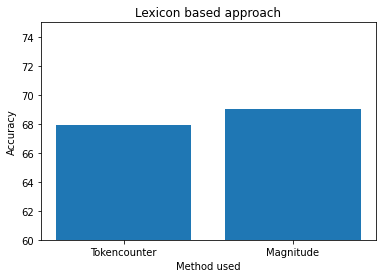

In [14]:
accuracies = [token_accuracy, magnitude_accuracy]
x = ['Tokencounter', 'Magnitude']

axes = plt.gca()
axes.set_ylim([60,75])
plt.bar(x,accuracies)
axes.set_ylabel('Accuracy')
axes.set_xlabel('Method used')
plt.title('Lexicon based approach')
plt.show()

## (Q1.3 Optional) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

*Write your answer here.*

The problem with the threshold being length-invariant is the fact that shorter reviews will automatically get classified as negative, because the probabilty that the document has 8 positive sentiment words is very small. And conversely, it also a problem for very long reviws, since the probability that there are more than 8 positive sentiment words is higher, even though there still could be high number of negative words present. 

An alternative way to compute the treshold could be:

First compute the average document length and assume that the threshold for the average length is equal to 8.

To compute the threshold: 

    -Take a document
    -Divide its length by the average length
    -Multiply with 8


# Significance testing

Does using the magnitude improve the results? Oftentimes, answering such questions by simply comparing accuracy
scores is not enough. When dealing with natural language and human ratings, it is safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are due to mere chance.

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 

In this experiment, $q = 0.5$, so the formula simplifies to:
$$2\times 0.5^N\, \sum\limits_{i=0}^{k} \binom{N}{i}$$


We use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.


In [15]:
from decimal import Decimal
from scipy.special import comb


def sign_test(results_1, results_2):
  """test for significance"""
  ties, plus, minus = 0, 0, 0

  for i in range(0, len(results_1)):
    if results_1[i]==results_2[i]:
      ties += 1
    elif results_1[i]==0: 
      plus += 1
    elif results_2[i]==0: 
      minus += 1

  n = (2 * math.ceil(ties/2.0)) + plus + minus
  k = math.ceil(ties/2.0) + min(plus,minus)

  summation = Decimal(0.0)
  for i in range(0,int(k)+1):
      summation += (Decimal(comb(n,i,exact=True)))

  # use two-tailed version of test
  summation *= 2
  summation *= (Decimal(0.5)**Decimal(n))
  
  print("the difference is", 
        "not significant" if summation >= 0.05 else "significant")
  
  return summation

p_value = sign_test(token_results, magnitude_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.6548123008131539579058732112


### Using the Sign test

**From now on, report all differences between systems, as well as between system configurations, using the
sign test.**
    
You should report statistical test
results in an appropriate form. If there are several different methods
(i.e., systems) to compare, the Sign test can only be applied to pairs of them
at a time. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


# Naive Bayes (10pt)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q3.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**. 

In case 2, you could also set $P(c|\bar{f}) = 0$ for the class $c$ within which $f_i \in \bar{f}$ was not seen. One way to implement this in log space is to set $P(c|\bar{f}) = -\infty$. What would be the problem instead with skipping words only for one class in case 2? 

ANSWER:

If the word that is unseen in one of two classes, would be skipped for only that class, there would be an implicit present in our model. This way there is unfair comparison between the two classes when trying to classify them, because the class for which the word in question, simply has less features than the other class. If this happens often, the implicit bias will keep increasing, making it even more unfair. The possible solution that is given above, would imply that instead of adding 0, a very small number would be added to the probabilty of the class in which the word is not present, however this essentially gives the same problem, as the added amount is very close to zero. Therefore there is still an unfair advantage, hence it is better to skip the word for both classes. 

#### (Q3.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [187]:
### NB (train)
import copy
### First make vocabulary
vocabulary = {}


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


# fill vocab with all unique words 
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabulary[word] = 0
    if i == 899:
        break

# fill vocab with all unique words so this is a dict with all the words in the reviews
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
#             print(a)
            vocabulary[word] = 0
    if i == 899:
        break

CondProbDict = vocabulary
CondProbDict = copy.deepcopy(CondProbDict)

wordcounterPos = vocabulary
wordcounterPos = copy.deepcopy(wordcounterPos)

wordcounterNeg = vocabulary
wordcounterNeg = copy.deepcopy(wordcounterNeg)


# count for each word its occurence
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            wordcounterPos[word] += 1
    if i == 899:
        break
        
# count for each word its occurence
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            
            wordcounterNeg[word] += 1
    if i == 899:
        break

        
        
        
totalcountPos = sum(wordcounterPos.values())
totalcountNeg = sum(wordcounterNeg.values())

# print(totalcountNeg, totalcountPos)

wordcounterPos = {k: v for k, v in wordcounterPos.items() if v != 0}
wordcounterNeg = {k: v for k, v in wordcounterNeg.items() if v != 0}




for key,value in CondProbDict.items():
    
#   if word in neg and pos
    if key in wordcounterPos and key in wordcounterNeg:
 
        CondProbDict[key] =  [wordcounterPos[key]/totalcountPos, wordcounterNeg[key]/totalcountNeg]
        
# print(CondProbDict)


        
negPrior = len(negativeReviews) / (len(positiveReviews) + len(negativeReviews))
posPrior = len(positiveReviews) / (len(positiveReviews) + len(negativeReviews))
                


In [188]:
### NB (test)
# load in test data

results = []
labels = []

for x in range(2):
    i = x
    for y in range(100):
        labels.append(i)

negativeReviewsTest = reviews[900:1000]
positiveReviewsTest = reviews[1900:]
testData = negativeReviewsTest + positiveReviewsTest  

# loop door elke review heen in test data
# per review bepaal de class prob voor neg and pos
# pak de hoogste hooste prob 

for i, r in enumerate(testData):
    text = r["content"] 
    
    posProb = 0
    negProb = 0
    for x in text:
        
        for a in x:
            word = a[0].lower()
            
            # make sure that test word voorkomt in both dictionaries
            if word in CondProbDict and CondProbDict[word] != 0:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0])
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            
    posProb += np.log(posPrior)
    negProb += np.log(negPrior)
    if posProb > negProb:
        results.append(1)
    else:
        results.append(0)
                
amount_of_correct = 0
for r, l in zip(results, labels):
    if r == l:
        amount_of_correct += 1


nb_accuracy = (amount_of_correct / len(labels) * 100)
print("Accuracy: %0.2f" % nb_accuracy)



Accuracy: 82.50


#### (Q3.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [189]:
### NB with imbalanced data (train)
import copy
### First make vocabulary
vocabulary = {}


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


# fill vocab with all unique words 
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabulary[word] = 0
    if i == 899:
        break

# fill vocab with all unique words so this is a dict with all the words in the reviews
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabulary[word] = 0
    if i == 89:
        break

CondProbDict = vocabulary
CondProbDict = copy.deepcopy(CondProbDict)

wordcounterPos = vocabulary
wordcounterPos = copy.deepcopy(wordcounterPos)

wordcounterNeg = vocabulary
wordcounterNeg = copy.deepcopy(wordcounterNeg)


# count for each word its occurence
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            wordcounterPos[word] += 1
    if i == 899:
        break
        
# count for each word its occurence
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            
            wordcounterNeg[word] += 1
    if i == 89:
        break

        
        
        
totalcountPos = sum(wordcounterPos.values())
totalcountNeg = sum(wordcounterNeg.values())

wordcounterPos = {k: v for k, v in wordcounterPos.items() if v != 0}
wordcounterNeg = {k: v for k, v in wordcounterNeg.items() if v != 0}





for key,value in CondProbDict.items():
    
#   if word in neg and pos
    if key in wordcounterPos and key in wordcounterNeg:
 
        CondProbDict[key] =  [wordcounterPos[key]/totalcountPos, wordcounterNeg[key]/totalcountNeg]
        


negPrior = 90 / (len(positiveReviews) + len(negativeReviews))
posPrior = len(positiveReviews) / (len(positiveReviews) + len(negativeReviews))
                


In [190]:
### NB with imbalanced data (test)
# load in test data

resultsImb = []
labels = []

for x in range(10):
    labels.append(0)
for x in range(100):
    labels.append(1)

negativeReviewsTest = reviews[900:909]
positiveReviewsTest = reviews[1900:]
testData = negativeReviewsTest + positiveReviewsTest  

# loop door elke review heen in test data
# per review bepaal de class prob voor neg and pos
# pak de hoogste hooste prob 

for i, r in enumerate(testData):
    text = r["content"] 
    
    posProb = 0
    negProb = 0
    for x in text:
        
        for a in x:
            word = a[0].lower()
            
            # make sure that test word voorkomt in both dictionaries
            if word in CondProbDict and CondProbDict[word] != 0:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
                
#     print("PRIORR", np.log(posPrior))
#     print(posProb)
    posProb += np.log(posPrior)
    negProb += np.log(negPrior)
    if posProb > negProb:
        resultsImb.append(1)
    else:
        resultsImb.append(0)
        
amount_of_correct = 0
for r, l in zip(resultsImb, labels):
    if r == l:
        amount_of_correct += 1


nb_accuracy = (amount_of_correct / len(labels) * 100)
print("Accuracy: %0.2f" % nb_accuracy)
        
# nb_accuracy = (sum(results)/sum(labels) ) * 100
# print("Accuracy: %0.2f" % nb_accuracy)

# # print(results)




# door de deling zijn de negatieve probs per woord veel hoger in verhouding van de positieve probs 

# daardoor zal hij gemiddeld gezien veel vaker een review als negatief classificeren

# terwijl je veel meer traint op positief ... maar dit komt omdat de probabilities van een woord in de positieve en negatieve 
# classe worden gedeeld door de som van hun eigen aantal. dus het aantal keer dat "dog" voorkomt in neg / aantal worden in neg

Accuracy: 58.18


## Answer to Q3.3
No, accuracy is not a measurement for a imbalanced dataset. This is because a classifier can easily get a high accuracy without actually doing a good job in classifying datapoints. It can simply all the datapoints for the class that is more present in the trainig data.

This models (naive bayes) makes a mistake in calculating the probabilties for a word given a class. This is because you count the amount of times a word occurs in a negative review but you also divide by the total number of words in negative reviews. Because the total amount of words in negative reviews is low, you simply always divide by a relative low number and thus ends up with a high probability. But this is not a fair comparison for the positive class where you divide by a much higher total amount of positive words and thus end up in a lower probability. 

## Smoothing (1.5pts)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [192]:
### NB with smoothing (train)


import copy
k = 1
### First make vocabulary
vocabulary = {}


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


# fill vocab with all unique words 
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabulary[word] = 0
    if i == 899:
        break

# fill vocab with all unique words so this is a dict with all the words in the reviews
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabulary[word] = 0
    if i == 899:
        break

CondProbDict = vocabulary
CondProbDict = copy.deepcopy(CondProbDict)


wordcounterPos = vocabulary
wordcounterPos = copy.deepcopy(wordcounterPos)

wordcounterNeg = vocabulary
wordcounterNeg = copy.deepcopy(wordcounterNeg)


# count for each word its occurence
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            wordcounterPos[word] += 1
    if i == 899:
        break
        
# count for each word its occurence
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            
            wordcounterNeg[word] += 1
    if i == 899:
        break

        
        
        
totalcountPos = sum(wordcounterPos.values())
totalcountNeg = sum(wordcounterNeg.values())


for key,value in CondProbDict.items():
    CondProbDict[key] =  [( wordcounterPos[key] + k) / (totalcountPos + len(CondProbDict)), 
                          ( wordcounterNeg[key] + k) / (totalcountNeg + len(CondProbDict))]
        
negPrior = 900 / 1800
posPrior = 900 / 1800

                


In [193]:
### NB with smoothing (test)
# load in test data

resultsSmooth = []
labels = []

for x in range(2):
    i = x
    for y in range(100):
        labels.append(i)

negativeReviewsTest = reviews[900:1000]
positiveReviewsTest = reviews[1900:]
testData = negativeReviewsTest + positiveReviewsTest  

# loop door elke review heen in test data
# per review bepaal de class prob voor neg and pos
# pak de hoogste hooste prob 

for i, r in enumerate(testData):
    text = r["content"] 
    
    posProb = 0
    negProb = 0
    for x in text:
        
        for a in x:
            word = a[0].lower()
            
            # make sure that test word voorkomt in both dictionaries
#             if word in CondProbDict and CondProbDict[word] != 0:
            if word in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0])
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))
            
    posProb += np.log(posPrior)
    negProb += np.log(negPrior)

    if posProb > negProb:
        resultsSmooth.append(1)
    else:
        resultsSmooth.append(0)
        
amount_of_correct = 0
for r, l in zip(resultsSmooth, labels):
    if r == l:
        amount_of_correct += 1


nb_accuracy = (amount_of_correct / len(labels) * 100)
print("Accuracy: %0.2f" % nb_accuracy)

Accuracy: 82.50


#### (Q3.5) Is the difference between non smoothed (Q3.2) and smoothed (Q3.4) statistically significant? (0.5pt)

In [194]:
p_value = sign_test(resultsSmooth, results)
print(p_value)

the difference is not significant
1.056348479009256422247245265


The difference between the smoothed and non smoothed methods is not significant. This is because the p-value from the given function is much higher than 0.05. 

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q3.6) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [154]:
### Helper functions



### Create the folds
def make_folds(positiveReviews,negativeReviews, stemming):
    folds_dict_pos = {}
    
    if stemming:
        stemmer = PorterStemmer()
    for x in range(10):
        folds_dict_pos[x] = []

    for i, r in enumerate(positiveReviews):

        text = r["content"] 
        words_in_review = []
        for x in text:
            for a in x:
                word = a[0].lower()
                if stemming:
                    word= stemmer.stem(word)
                words_in_review.append(word)

        current_list = folds_dict_pos[i % 10]
        new_list = current_list + [words_in_review]

        folds_dict_pos[i % 10] = new_list

    # # fill vocab with all unique words 
    folds_dict_neg = {}
    for x in range(10):
        folds_dict_neg[x] = []

    for i, r in enumerate(negativeReviews):

        text = r["content"] 
        words_in_review = []
        for x in text:
            for a in x:
                word = a[0].lower()
                if stemming:
                    word= stemmer.stem(word)
                words_in_review.append(word)

        current_list = folds_dict_neg[i % 10]
        new_list = current_list + [words_in_review]

        folds_dict_neg[i % 10] = new_list
    return folds_dict_pos, folds_dict_neg


###Get the training data given the test fold 
def pick_training_boiz(test_fold, fold_dict):
    
    data_list = []
    
    for fold in range(10):
        if fold != test_fold:
            data_list.append(fold_dict[fold])
            
    return data_list

N.B:
Since we had to reimplement the Naive Bayes from question 3.2, we did not implement smoothing. 

In [155]:
############# NB with round robin CV


from tqdm import tqdm

folds_dict_pos, folds_dict_neg = make_folds(positiveReviews, negativeReviews, False)

accuracies = []

# we trainen 10 keer, dus elke loop is een andere fold de test fold
for n_fold in tqdm(range(10)):
    
    # selecteer test folds
    test_pos = folds_dict_pos[n_fold]
    test_neg = folds_dict_neg[n_fold]
    
    # selecteer de training data 
    train_pos = pick_training_boiz(n_fold, folds_dict_pos)
    train_neg = pick_training_boiz(n_fold, folds_dict_neg)
    
    fold_vocab = {}
    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            for word in review:
                fold_vocab[word.lower()] = 0

            
    for fold in train_neg:
        for review in fold:
            for word in review:
                fold_vocab[word.lower()] = 0
                
    
    CondProbDict = fold_vocab
    CondProbDict = copy.deepcopy(CondProbDict)

    wordcounterPos = fold_vocab
    wordcounterPos = copy.deepcopy(wordcounterPos)

    wordcounterNeg = fold_vocab
    wordcounterNeg = copy.deepcopy(wordcounterNeg)    
    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            for word in review:
                if word in wordcounterPos:
                    wordcounterPos[word.lower()] += 1
            
    for fold in train_neg:
        for review in fold:
            for word in review:
                if word in wordcounterNeg:
                    wordcounterNeg[word.lower()] += 1
    
    totalcountPos = sum(wordcounterPos.values())
    totalcountNeg = sum(wordcounterNeg.values())
    
    print(len(wordcounterPos))
    print(len(wordcounterNeg))

    wordcounterPos = {k: v for k, v in wordcounterPos.items() if v != 0}
    wordcounterNeg = {k: v for k, v in wordcounterNeg.items() if v != 0}

    for key,value in CondProbDict.items():
        if key in wordcounterPos and key in wordcounterNeg:
            CondProbDict[key] =  [wordcounterPos[key]/totalcountPos, wordcounterNeg[key]/totalcountNeg]

    posPrior = len(train_pos) / (len(train_pos) + len(train_neg))
    negPrior = len(train_neg) / (len(train_pos) + len(train_neg))
    
    results = []
    labels = []
    
    for review in test_pos:
        posProb = 0
        negProb = 0
        for word in review:
            # make sure that test word voorkomt in both dictionaries
            if word.lower() in CondProbDict and CondProbDict[word.lower()] != 0:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word.lower()][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word.lower()][1])

        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
        else:
            results.append(0)

        labels.append(1)
        
    for review in test_neg:
                
        posProb = 0
        negProb = 0
        for word in review:
            
            # make sure that test word voorkomt in both dictionaries
            if word.lower() in CondProbDict and CondProbDict[word.lower()] != 0:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word.lower()][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word.lower()][1])

        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
        else:
            results.append(0)
        
        labels.append(0)
    
    amount_of_correct = 0
    for r, l in zip(results, labels):
        if r == l:
            amount_of_correct += 1

    accuracies.append( (amount_of_correct / len(labels)) * 100)

accuracy = sum(accuracies)/len(accuracies)

    


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

45329
45329


 10%|████████▎                                                                          | 1/10 [00:01<00:15,  1.77s/it]

45392
45392


 20%|████████████████▌                                                                  | 2/10 [00:03<00:13,  1.74s/it]

45438
45438


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:12,  1.73s/it]

45389
45389


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:10,  1.71s/it]

45648
45648


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:08<00:08,  1.69s/it]

45296
45296


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:10<00:06,  1.69s/it]

45365
45365


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:11<00:05,  1.69s/it]

45409
45409


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.69s/it]

45557
45557


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:15<00:01,  1.70s/it]

45642
45642


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


#### (Q3.7) Write code to calculate and report the variance of the 10 accuracy scores, in addition to the final performance. You must not use a library, such as numpy. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [156]:
def calc_variance(accuracies):
    mean = sum(accuracies)/len(accuracies)
    
    summ = 0
    for acc in accuracies:
        summ += (acc - mean)**2
    
    return (1/len(accuracies))*summ

variance = calc_variance(accuracies)

print("Variance of accuracies in Cross Validation: ", variance)
print("Accuracy of Naive Bayes with Cross Validation: ", accuracy)

Variance of accuracies in Cross Validation:  7.740000000000002
Accuracy of Naive Bayes with Cross Validation:  81.4


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.

You should also perform cross-validation. Concatenate the predictions from all folds to compute the significance.

In [157]:
############### NB with stemming and CV


from nltk.stem import *
from tqdm import tqdm


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


folds_dict_pos, folds_dict_neg = make_folds(positiveReviews, negativeReviews, True)


# fill vocab with all unique words 

#### Set K for smoothing

k = 1 
    
accuraciesStem = []
all_fold_predictions_stem = []

# we trainen 10 keer, dus elke loop is een andere fold de test fold
for n_fold in tqdm(range(10)):
    
    print("HALLOO")
    # selecteer test folds
    test_pos = folds_dict_pos[n_fold]
    test_neg = folds_dict_neg[n_fold]
    
    # selecteer de training data 
    train_pos = pick_training_boiz(n_fold, folds_dict_pos)
    train_neg = pick_training_boiz(n_fold, folds_dict_neg)
    
    fold_vocab = {}
    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            for word in review:
                fold_vocab[word] = 0

            
    for fold in train_neg:
        for review in fold:
            for word in review:
                fold_vocab[word] = 0
                
    
    CondProbDict = fold_vocab
    CondProbDict = copy.deepcopy(CondProbDict)

    wordcounterPos = fold_vocab
    wordcounterPos = copy.deepcopy(wordcounterPos)

    wordcounterNeg = fold_vocab
    wordcounterNeg = copy.deepcopy(wordcounterNeg)    
    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            for word in review:
                if word in wordcounterPos:
                    wordcounterPos[word] += 1
            
    for fold in train_neg:
        for review in fold:
            for word in review:
                if word in wordcounterNeg:
                    wordcounterNeg[word] += 1
    
    totalcountPos = sum(wordcounterPos.values())
    totalcountNeg = sum(wordcounterNeg.values())
    print(len(wordcounterPos))
    print(len(wordcounterNeg))    

    for key,value in CondProbDict.items():
        CondProbDict[key] =  [(wordcounterPos[key]+k)/(totalcountPos+len(CondProbDict)), 
                              (wordcounterNeg[key]+k)/(totalcountNeg+len(CondProbDict))]

    posPrior = len(train_pos) / (len(train_pos) + len(train_neg))
    negPrior = len(train_neg) / (len(train_pos) + len(train_neg))
    
    results = []
    labels = []
    
    for review in test_pos:
        posProb = 0
        negProb = 0
        for word in review:
            # make sure that test word voorkomt in both dictionaries
            if word in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))

        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
            all_fold_predictions_stem.append(1)
        else:
            results.append(0)
            all_fold_predictions_stem.append(0)

        labels.append(1)
        
        
    for review in test_neg:
                
        posProb = 0
        negProb = 0
        for word in review:
            
            # make sure that test word voorkomt in both dictionaries
            if word in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))

        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
            all_fold_predictions_stem.append(1)
        else:
            results.append(0)
            all_fold_predictions_stem.append(0)
        
        labels.append(0)
    
    amount_of_correct = 0
    for r, l in zip(results, labels):
        if r == l:
            amount_of_correct += 1

    accuraciesStem.append( (amount_of_correct / len(labels)) * 100)

accuracyStem = sum(accuraciesStem)/len(accuraciesStem)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

HALLOO
32371
32371


 10%|████████▎                                                                          | 1/10 [00:01<00:12,  1.42s/it]

HALLOO
32482
32482


 20%|████████████████▌                                                                  | 2/10 [00:02<00:11,  1.40s/it]

HALLOO
32545
32545


 30%|████████████████████████▉                                                          | 3/10 [00:04<00:09,  1.41s/it]

HALLOO
32498
32498


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.57s/it]

HALLOO
32699
32699


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:07,  1.51s/it]

HALLOO
32439
32439


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:08<00:05,  1.46s/it]

HALLOO
32440
32440


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:10<00:04,  1.43s/it]

HALLOO
32493
32493


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:11<00:02,  1.40s/it]

HALLOO
32576
32576


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:12<00:01,  1.38s/it]

HALLOO
32667
32667


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Since in Q3.6 we were asked to reimplement the NB from 3.2, we did not implement smoothing. We will implement smoothing with cross validation in the cell below.

In [158]:
############### NB without stemming and with CV


# fill vocab with all unique words 


from tqdm import tqdm


# Set k for smoothing

k = 1

folds_dict_pos, folds_dict_neg = make_folds(positiveReviews, negativeReviews, False)
    
accuraciesNostem = []

all_folds_predictions_nostem = []


# we trainen 10 keer, dus elke loop is een andere fold de test fold
for n_fold in tqdm(range(10)):
    
    # selecteer test folds
    test_pos = folds_dict_pos[n_fold]
    test_neg = folds_dict_neg[n_fold]
    
    # selecteer de training data 
    train_pos = pick_training_boiz(n_fold, folds_dict_pos)
    train_neg = pick_training_boiz(n_fold, folds_dict_neg)
    
    fold_vocab = {}
    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            for word in review:
                fold_vocab[word.lower()] = 0

            
    for fold in train_neg:
        for review in fold:
            for word in review:
                fold_vocab[word.lower()] = 0
                
    
    CondProbDict = fold_vocab
    CondProbDict = copy.deepcopy(CondProbDict)

    wordcounterPos = fold_vocab
    wordcounterPos = copy.deepcopy(wordcounterPos)

    wordcounterNeg = fold_vocab
    wordcounterNeg = copy.deepcopy(wordcounterNeg)    
    
    

    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            for word in review:
                if word in wordcounterPos:
                    wordcounterPos[word.lower()] += 1
            
    for fold in train_neg:
        for review in fold:
            for word in review:
                if word in wordcounterNeg:
                    wordcounterNeg[word.lower()] += 1
    
    totalcountPos = sum(wordcounterPos.values())
    totalcountNeg = sum(wordcounterNeg.values())
    
    print(len(wordcounterPos))
    print(len(wordcounterNeg))

    #wordcounterPos = {k: v for k, v in wordcounterPos.items() if v != 0}
    #wordcounterNeg = {k: v for k, v in wordcounterNeg.items() if v != 0}

    for key,value in CondProbDict.items():

    #   if word in neg and pos
        if key in wordcounterPos and key in wordcounterNeg:
            CondProbDict[key] =  [(wordcounterPos[key]+k)/(totalcountPos+len(CondProbDict))
                                   , (wordcounterNeg[key]+k)/(totalcountNeg+len(CondProbDict))]

    posPrior = len(train_pos) / (len(train_pos) + len(train_neg))
    negPrior = len(train_neg) / (len(train_pos) + len(train_neg))
    
    results = []
    labels = []
    
    for review in test_pos:
        posProb = 0
        negProb = 0
        for word in review:
            # make sure that test word voorkomt in both dictionaries
            if word.lower() in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))

        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
            all_folds_predictions_nostem.append(1)
        else:
            results.append(0)
            all_folds_predictions_nostem.append(0)

        labels.append(1)
        
        
    for review in test_neg:
                
        posProb = 0
        negProb = 0
        for word in review:
            
            # make sure that test word voorkomt in both dictionaries
            if word.lower() in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))
                
        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
            all_folds_predictions_nostem.append(1)               
        else:
            results.append(0)
            all_folds_predictions_nostem.append(0)
        
        labels.append(0)
    
    amount_of_correct = 0
    for r, l in zip(results, labels):
        if r == l:
            amount_of_correct += 1

    accuraciesNostem.append( (amount_of_correct / len(labels)) * 100)

accuracyNostem = sum(accuraciesNostem)/len(accuraciesNostem)

    


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

45329
45329


 10%|████████▎                                                                          | 1/10 [00:01<00:16,  1.84s/it]

45392
45392


 20%|████████████████▌                                                                  | 2/10 [00:03<00:14,  1.80s/it]

45438
45438


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:12,  1.77s/it]

45389
45389


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:10,  1.74s/it]

45648
45648


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:08<00:08,  1.71s/it]

45296
45296


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:10<00:07,  1.81s/it]

45365
45365


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:12<00:05,  1.77s/it]

45409
45409


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.73s/it]

45557
45557


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:15<00:01,  1.72s/it]

45642
45642


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


#### (Q3.9): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (1pt)


In [159]:
print("Accuracy NB with stemming and CV: ", accuracyStem)
print("Accuracy NB without stemming and with CV: ", accuracyNostem)
print("-------------------------------------------")
print("Variance of NB with stemming and CV: ", calc_variance(accuraciesStem))
print("Variance of NB without stemming and with CV: ", calc_variance(accuraciesNostem))
print("-------------------------------------------")
p_value = sign_test(all_fold_predictions_stem, all_folds_predictions_nostem)
print(p_value)

Accuracy NB with stemming and CV:  81.45
Accuracy NB without stemming and with CV:  81.7
-------------------------------------------
Variance of NB with stemming and CV:  7.5725
Variance of NB without stemming and with CV:  6.51
-------------------------------------------
the difference is not significant
0.7885063327970648392413730178


There is not a significant difference between the predictions using stemming and the ones without. Even though our accuracy is a bit lower, we think that the classifier is more robust making it generalize better. This is because all the words are stemmed, reducing the number of outliers which will reduce the amount of overfitting on the training data, caused by noise.  

#### (Q3.10) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [109]:
### First calculate vocabulary using only .lower()

import copy
k = 1
### First make vocabulary
vocabularyNostem = {}


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


# fill vocab with all unique words 
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabularyNostem[word] = 0
    if i == 899:
        break

# fill vocab with all unique words so this is a dict with all the words in the reviews
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabularyNostem[word] = 0
    if i == 899:
        break
        
print("Length of vocabulary without stemming: ",len(vocabularyNostem))

###Calculate vocabulary with stemming
from nltk.stem import *

stemmer = PorterStemmer()
k = 1
### First make vocabulary
vocabularyStem = {}


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


# fill vocab with all unique words 
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = stemmer.stem(a[0])
            vocabularyStem[word] = 0
    if i == 899:
        break

# fill vocab with all unique words so this is a dict with all the words in the reviews
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = stemmer.stem(a[0])
            vocabularyStem[word] = 0
    if i == 899:
        break
        
print("Length of vocabulary with stemming: ",len(vocabularyStem))

Length of vocabulary without stemming:  45348
Length of vocabulary without stemming:  32561


So it is clear that when using stemming, the amount of features decreases.

### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-gram** features. 






#### (Q3.11) Retrain your classifier from (Q3.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and statistical significances (in comparison to the experiment at (Q3.6) for all 10 folds, and between the new systems). You are allowed to use NLTK to build n-grams from sentences.

In [160]:
############### NB with unigram+bigram features and with CV
# fill vocab with all unique words 


from tqdm import tqdm


# Set k for smoothing

k = 1

folds_dict_pos, folds_dict_neg = make_folds(positiveReviews, negativeReviews, False)
    
accuraciesBigram = []

all_folds_predictions_Bigram = []


# we trainen 10 keer, dus elke loop is een andere fold de test fold
for n_fold in tqdm(range(10)):
    
    # selecteer test folds
    test_pos = folds_dict_pos[n_fold]
    test_neg = folds_dict_neg[n_fold]
    
    # selecteer de training data 
    train_pos = pick_training_boiz(n_fold, folds_dict_pos)
    train_neg = pick_training_boiz(n_fold, folds_dict_neg)
    
    fold_vocab = {}
    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            bigrams_in_review = list(nltk.bigrams(review))
            for word in review:
                fold_vocab[word.lower()] = 0
            for bigram in bigrams_in_review :
                fold_vocab[bigram] = 0

            
    for fold in train_neg:
        for review in fold:
            bigrams_in_review = list(nltk.bigrams(review))
            for word in review:
                fold_vocab[word.lower()] = 0
            for bigram in bigrams_in_review :
                fold_vocab[bigram] = 0

                
    
    CondProbDict = fold_vocab
    CondProbDict = copy.deepcopy(CondProbDict)

    wordcounterPos = fold_vocab
    wordcounterPos = copy.deepcopy(wordcounterPos)

    wordcounterNeg = fold_vocab
    wordcounterNeg = copy.deepcopy(wordcounterNeg)    
    
    

    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            bigrams_in_review = list(nltk.bigrams(review))
            for word in review:
                if word in wordcounterPos:
                    wordcounterPos[word.lower()] += 1
            for bigram in bigrams_in_review :
                if bigram in wordcounterPos:
                    wordcounterPos[bigram] += 1
            
    for fold in train_neg:
        for review in fold:
            bigrams_in_review = list(nltk.bigrams(review))
            for word in review:
                if word in wordcounterNeg:
                    wordcounterNeg[word.lower()] += 1
            for bigram in bigrams_in_review :
                if bigram in wordcounterNeg:
                    wordcounterNeg[bigram] += 1
    
    totalcountPos = sum(wordcounterPos.values())
    totalcountNeg = sum(wordcounterNeg.values())
    
    print(len(wordcounterPos))
    print(len(wordcounterNeg))

    for key,value in CondProbDict.items():

        if key in wordcounterPos and key in wordcounterNeg:
            CondProbDict[key] =  [(wordcounterPos[key]+k)/(totalcountPos+len(CondProbDict))
                                   , (wordcounterNeg[key]+k)/(totalcountNeg+len(CondProbDict))]

    posPrior = len(train_pos) / (len(train_pos) + len(train_neg))
    negPrior = len(train_neg) / (len(train_pos) + len(train_neg))
    
    results = []
    labels = []
    
    for review in test_pos:
        posProb = 0
        negProb = 0
        bigrams_in_review = list(nltk.bigrams(review))
        for word in review:
            # make sure that test word voorkomt in both dictionaries
            if word in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))
        for bigram in bigrams_in_review:
            if bigram in CondProbDict:
                #print("BIGRAM IN POS", bigram)
                # bepaal pos prob
                posProb += np.log(CondProbDict[bigram][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[bigram][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))
        #print(posProb)
        #print(negProb)

        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
            all_folds_predictions_Bigram.append(1)
        else:
            results.append(0)
            all_folds_predictions_Bigram.append(0)

        labels.append(1)
        
        
    for review in test_neg:
                
        posProb = 0
        negProb = 0
        bigrams_in_review = list(nltk.bigrams(review))
        for word in review:
            # make sure that test word voorkomt in both dictionaries
            if word.lower() in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))
        for bigram in bigrams_in_review:
            if bigram in CondProbDict:
                #print("BIGRAM IN neg", bigram)
                # bepaal pos prob
                posProb += np.log(CondProbDict[bigram][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[bigram][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))   
        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
            all_folds_predictions_Bigram.append(1)               
        else:
            results.append(0)
            all_folds_predictions_Bigram.append(0)
        
        labels.append(0)
    amount_of_correct = 0
    for r, l in zip(results, labels):
        if r == l:
            amount_of_correct += 1

    accuraciesBigram.append( (amount_of_correct / len(labels)) * 100)

accuracyBigram = sum(accuraciesBigram)/len(accuraciesBigram)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

472632
472632


 10%|████████▎                                                                          | 1/10 [00:11<01:40, 11.21s/it]

470090
470090


 20%|████████████████▌                                                                  | 2/10 [00:22<01:29, 11.22s/it]

471219
471219


 30%|████████████████████████▉                                                          | 3/10 [00:34<01:19, 11.42s/it]

470615
470615


 40%|█████████████████████████████████▏                                                 | 4/10 [00:46<01:10, 11.68s/it]

474505
474505


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:58<00:59, 11.83s/it]

470209
470209


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:10<00:46, 11.71s/it]

469410
469410


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:21<00:35, 11.70s/it]

471005
471005


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:33<00:23, 11.66s/it]

473245
473245


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:45<00:11, 11.71s/it]

473084
473084


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:56<00:00, 11.65s/it]


In [161]:
############### NB with unigram+bigram+trigram features and with CV
# fill vocab with all unique words 


from tqdm import tqdm


# Set k for smoothing

k = 1

folds_dict_pos, folds_dict_neg = make_folds(positiveReviews, negativeReviews, False)
    
accuraciesBiTrigram = []

all_folds_predictions_BiTrigram = []


# we trainen 10 keer, dus elke loop is een andere fold de test fold
for n_fold in tqdm(range(10)):
    
    # selecteer test folds
    test_pos = folds_dict_pos[n_fold]
    test_neg = folds_dict_neg[n_fold]
    
    # selecteer de training data 
    train_pos = pick_training_boiz(n_fold, folds_dict_pos)
    train_neg = pick_training_boiz(n_fold, folds_dict_neg)
    
    fold_vocab = {}
    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            bigrams_in_review = list(nltk.bigrams(review))
            trigrams_in_review = list(nltk.trigrams(review))
            for word in review:
                fold_vocab[word.lower()] = 0
            for bigram in bigrams_in_review :
                fold_vocab[bigram] = 0
            for trigram in trigrams_in_review :
                fold_vocab[trigram] = 0


            
    for fold in train_neg:
        for review in fold:
            bigrams_in_review = list(nltk.bigrams(review))
            trigrams_in_review = list(nltk.trigrams(review))
            for word in review:
                fold_vocab[word.lower()] = 0
            for bigram in bigrams_in_review :
                fold_vocab[bigram] = 0
            for trigram in trigrams_in_review :
                fold_vocab[trigram] = 0
                
    
    CondProbDict = fold_vocab
    CondProbDict = copy.deepcopy(CondProbDict)

    wordcounterPos = fold_vocab
    wordcounterPos = copy.deepcopy(wordcounterPos)

    wordcounterNeg = fold_vocab
    wordcounterNeg = copy.deepcopy(wordcounterNeg)    
    
    

    
    # loop door de 9 folds die training data bevatten
    for fold in train_pos:
        for review in fold:
            bigrams_in_review = list(nltk.bigrams(review))
            trigrams_in_review = list(nltk.trigrams(review))
            for word in review:
                if word in wordcounterPos:
                    wordcounterPos[word.lower()] += 1
            for bigram in bigrams_in_review :
                if bigram in wordcounterPos:
                    wordcounterPos[bigram] += 1
            for trigram in trigrams_in_review :
                if trigram in wordcounterPos:
                    wordcounterPos[trigram] += 1
            
    for fold in train_neg:
        for review in fold:
            bigrams_in_review = list(nltk.bigrams(review))
            trigrams_in_review = list(nltk.trigrams(review))
            for word in review:
                if word in wordcounterNeg:
                    wordcounterNeg[word.lower()] += 1
            for bigram in bigrams_in_review :
                if bigram in wordcounterNeg:
                    wordcounterNeg[bigram] += 1
            for trigram in trigrams_in_review :
                if trigram in wordcounterNeg:
                    wordcounterNeg[trigram] += 1            
    
    totalcountPos = sum(wordcounterPos.values())
    totalcountNeg = sum(wordcounterNeg.values())
    
    print(len(wordcounterPos))
    print(len(wordcounterNeg))

    for key,value in CondProbDict.items():

        if key in wordcounterPos and key in wordcounterNeg:
            CondProbDict[key] =  [(wordcounterPos[key]+k)/(totalcountPos+len(CondProbDict))
                                   , (wordcounterNeg[key]+k)/(totalcountNeg+len(CondProbDict))]

    posPrior = len(train_pos) / (len(train_pos) + len(train_neg))
    negPrior = len(train_neg) / (len(train_pos) + len(train_neg))
    
    results = []
    labels = []
    
    for review in test_pos:
        posProb = 0
        negProb = 0
        bigrams_in_review = list(nltk.bigrams(review))
        trigrams_in_review = list(nltk.trigrams(review))
        for word in review:
            # make sure that test word voorkomt in both dictionaries
            if word in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))
        for bigram in bigrams_in_review:
            if bigram in CondProbDict:
                #print("BIGRAM IN POS", bigram)
                # bepaal pos prob
                posProb += np.log(CondProbDict[bigram][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[bigram][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))
        for trigram in trigrams_in_review:
            if trigram in CondProbDict:
                #print("BIGRAM IN POS", bigram)
                # bepaal pos prob
                posProb += np.log(CondProbDict[trigram][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[trigram][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))

        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
            all_folds_predictions_BiTrigram.append(1)
        else:
            results.append(0)
            all_folds_predictions_BiTrigram.append(0)

        labels.append(1)
        
        
    for review in test_neg:
                
        posProb = 0
        negProb = 0
        bigrams_in_review = list(nltk.bigrams(review))
        trigrams_in_review = list(nltk.trigrams(review))
        for word in review:
            # make sure that test word voorkomt in both dictionaries
            if word.lower() in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[word][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[word][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))
        for bigram in bigrams_in_review:
            if bigram in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[bigram][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[bigram][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))   
        for trigram in trigrams_in_review:
            if trigram in CondProbDict:
                # bepaal pos prob
                posProb += np.log(CondProbDict[trigram][0]) 
                # bepaal neg prob
                negProb += np.log(CondProbDict[trigram][1])
            else:
                posProb += np.log(1/(totalcountPos + len(CondProbDict)))
                negProb += np.log(1/(totalcountNeg + len(CondProbDict)))

        
        posProb += np.log(posPrior)
        negProb += np.log(negPrior)
        if posProb > negProb:
            results.append(1)
            all_folds_predictions_BiTrigram.append(1)               
        else:
            results.append(0)
            all_folds_predictions_BiTrigram.append(0)
        
        labels.append(0)
    amount_of_correct = 0
    for r, l in zip(results, labels):
        if r == l:
            amount_of_correct += 1

    accuraciesBiTrigram.append( (amount_of_correct / len(labels)) * 100)

accuracyBiTrigram = sum(accuraciesBiTrigram)/len(accuraciesBiTrigram)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

1423850
1423850


 10%|████████▎                                                                          | 1/10 [00:32<04:49, 32.13s/it]

1413520
1413520


 20%|████████████████▌                                                                  | 2/10 [01:04<04:18, 32.33s/it]

1417278
1417278


 30%|████████████████████████▉                                                          | 3/10 [01:37<03:46, 32.31s/it]

1415698
1415698


 40%|█████████████████████████████████▏                                                 | 4/10 [02:08<03:11, 31.99s/it]

1429108
1429108


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:39<02:39, 31.84s/it]

1416304
1416304


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:11<02:06, 31.73s/it]

1412319
1412319


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:42<01:34, 31.49s/it]

1418019
1418019


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:13<01:02, 31.43s/it]

1424267
1424267


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:44<00:31, 31.23s/it]

1422874
1422874


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:15<00:00, 31.51s/it]


In [145]:
print("Accuracy NB with bigrams and CV: ", accuracyBigram)
print("Accuracy NB with bigrams and trigrams and CV: ", accuracyBiTrigram)
print("-------------------------------------------")
print(accuraciesBigram)
print(accuraciesBiTrigram)
print("Variance of NB with Bigrams and CV: ", calc_variance(accuraciesBigram))
print("Variance of NB with Bigrams and Trigrams and with CV: ", calc_variance(accuraciesBiTrigram))
print("-------------------------------------------")
print("Significance test Bigram- Trigram")
p_value = sign_test(all_folds_predictions_Bigram, all_folds_predictions_BiTrigram)
print(p_value)

print("-------------------------------------------")
print("Significance test Bigram- 3.6")
p_value = sign_test(all_folds_predictions_Bigram, all_folds_predictions_nostem)
print(p_value)


Accuracy NB with bigrams and CV:  84.3
Accuracy NB with bigrams and trigrams and CV:  85.15
-------------------------------------------
[80.0, 87.5, 83.5, 87.0, 80.5, 87.0, 82.5, 84.0, 86.0, 85.0]
[80.0, 88.5, 85.0, 88.5, 81.5, 89.5, 83.5, 83.0, 87.5, 84.5]
Variance of NB with Bigrams and CV:  6.510000000000002
Variance of NB with Bigrams and Trigrams and with CV:  9.452500000000002
-------------------------------------------
Significance test Bigram- Trigram
the difference is not significant
0.2832481709581676163299477732
-------------------------------------------
Significance test Bigram- 3.6
the difference is not significant
0.2932785698870256137209886960



#### Q3.12: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q3.10)?

Use the held-out training set once again for this.


ANSWER:

Theoretically, we will expect that the size of the vocabulary will be squared when comparing unigrams and bigrams, since every words could be combined with every other word, which is not the case in practice, while rules for grammar and a finite number of documents will result in a lower number of combinations. 

From bigrams to trigrams, the same argument can be given. However the difference is even bigger, because with three words even more limitations regarding grammar and observations in the training data will result in way less number of tokens than the size of unigrams cubed. 

Comparing with question 3.10, it is clear that when using stemming, the size of the vocabulary will decrease, in contrast to using bigrams and/or trigrams. When comparing unigrams, bigrams and trigrams. We observe that, in practice, the size when using bigrams is 10 times the size of the unigram-vocabulary. The size when using trigrams is almost 3 times the size of the bigram-vocabulary. 

In [148]:
### First calculate vocabulary using only unigrams


vocabularyNostem = {}


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


# fill vocab with all unique words 
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabularyNostem[word] = 0
    if i == 899:
        break

# fill vocab with all unique words so this is a dict with all the words in the reviews
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    for x in text:
        for a in x:
            word = a[0].lower()
            vocabularyNostem[word] = 0
    if i == 899:
        break
        
print("Length of vocabulary with only Unigrams: ",len(vocabularyNostem))

###Calculate vocabulary with unigrams+bigrams

vocabularyBigram = {}


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


# fill vocab with all unique words 
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    words_in_review = []
    for x in text:
        for a in x:
            word = a[0]
            vocabularyBigram[word] = 0
            words_in_review.append(word)
    bigrams_in_review = list(nltk.bigrams(words_in_review))
    for bigram in bigrams_in_review:
        vocabularyBigram[bigram] = 0
    if i == 899:
        break

# fill vocab with all unique words so this is a dict with all the words in the reviews
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    words_in_review = []
    for x in text:
        for a in x:
            word = a[0]
            vocabularyBigram[word] = 0
            words_in_review.append(word)
    bigrams_in_review = list(nltk.bigrams(words_in_review))
    for bigram in bigrams_in_review:
        vocabularyBigram[bigram] = 0
    if i == 899:
        break
        
print("Length of vocabulary with Uni+Bigrams: ",len(vocabularyBigram))


###Calculate vocabulary with unigrams+bigrams+trigrams

vocabularyBiTrigram = {}


negativeReviews = reviews[0:1000]
positiveReviews = reviews[1000:2000]


# fill vocab with all unique words 
for i, r in enumerate(positiveReviews):
    text = r["content"] 
    words_in_review = []
    for x in text:
        for a in x:
            word = a[0]
            vocabularyBigram[word] = 0
            words_in_review.append(word)
    bigrams_in_review = list(nltk.bigrams(words_in_review))
    trigrams_in_review =list(nltk.trigrams(words_in_review))
    for bigram in bigrams_in_review:
        vocabularyBiTrigram[bigram] = 0
    for trigram in  trigrams_in_review:
        vocabularyBiTrigram[trigram] = 0
    if i == 899:
        break

# fill vocab with all unique words so this is a dict with all the words in the reviews
for i, r in enumerate(negativeReviews):
    text = r["content"] 
    words_in_review = []
    for x in text:
        for a in x:
            word = a[0]
            vocabularyBigram[word] = 0
            words_in_review.append(word)
    bigrams_in_review = list(nltk.bigrams(words_in_review))
    trigrams_in_review =list(nltk.trigrams(words_in_review))
    for bigram in bigrams_in_review:
        vocabularyBiTrigram[bigram] = 0
    for trigram in  trigrams_in_review:
        vocabularyBiTrigram[trigram] = 0
    if i == 899:
        break
        
print("Length of vocabulary with Uni+Bi+Trigrams: ",len(vocabularyBiTrigram))

Length of vocabulary with only Unigrams:  45348
Length of vocabulary with Uni+Bigrams:  500086
Length of vocabulary with Uni+Bi+Trigrams:  1410050


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q4.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing from (Q3.6) and report the numbers.
Perform cross-validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [ ]:
# YOUR CODE HERE

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Perform cross-validation and concatenate the predictions from all folds to compute the significance. Are the results significant? *Why?*  (1pt)


In [ ]:
# YOUR CODE HERE

*Write your answer here.*

#### (Q4.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Perform cross-validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? *Why?* (1pt)

In [ ]:
# YOUR CODE HERE

*Write your answer here.*

# (Q5) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


Discussion:

-Lexicon based approach (naïef)
    - lexicon met magnitude (iets beter maar niet veel)

-Naive Bayes (BOW - betere representatie van de review) maar wel probleem met nog nooit eerder voorgekomen  woorden
    - Smoothing (manier om P=0 te fixen)
    - Stemming (minder overfitten -> meer robust en generaliseerbaar
    - Ook tegen overfitten op de trainingdata -> cross validation -> ook voordeel als je weinig data hebt. 
    - Uni/Bi/Tri grams -> meer context in2acc 
-SVM -> Super tof ding Zeker ook met computer vision was echt super leuk
    - POS tags meer accuracy.


# Submission 


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 